# Research on DFB lasers  
---
目标 : 用Meep仿真出DFB的结构和给与源之后的结果
- 仿真Bragg Reflection
- 仿真QCL的材料layer结构
- 仿真光栅结构
- 组合查看仿真结果
- extra：mode intensity


## 基本概念介绍以及目的需求分析
---

### What is DFB?
- DFB 是 Distributed Feedback Laser（分布式反馈激光器）的缩写，是一种非常重要的单频激光器结构，广泛应用于光通信、光谱分析、传感和激光雷达等领域。
- DFB 激光器是一种在整个增益介质中内置周期性光栅，实现光反馈的激光器结构。
- 关键机制： Bragg Reflection 满足布拉格条件时，特定波长的光会被光栅强烈反射，并在有源区形成共振腔体，形成激光发射。
- 关于Bragg Reflection的相关机制探索，放在了另外一个notebook中。
> https://www.bilibili.com/video/BV1LR4y1G7aW/?spm_id_from=333.337.search-card.all.click&vd_source=94a597b5fbd359a011fb548c5a51fb78

### Why can use meep?
- Meep（MIT Electromagnetic Package）是一个开源的时域电磁波仿真软件，基于 FDTD 方法（Finite-Difference Time-Domain） 实现。
- 由于光具有波动性和粒子性，所以光可以看作是一种电磁波，满足麦克斯韦方程。
- 光的传播、干涉、反射、折射等都是波动现象。
- FDTD 将时间和空间离散，把麦克斯韦方程变成差分方程，在每一个时间步上逐步演化电场E和磁场H，得到时域中完整的光传播动画。

### What parameters of the material and grating structure should I use in meep and why?
| 参数                          | 必要性 | 含义                | Meep 中的字段                                          |
| --------------------------- | --- | ----------------- | -------------------------------------------------- |
| ✅ 折射率 `n` 或介电常数 `ε`         | 必须  | 光速变化与波传播方向的关键参数   | `index=` 或 `epsilon=`                              |
| ⚠️ 导电率 `σ`                  | 可选  | 模拟吸收材料的能量损耗       | `D_conductivity=`                                  |
| ⚠️ 色散参数（Drude / Lorentz 模型） | 可选  | 模拟频率相关的 ε（真实材料色散） | `LorentzianSusceptibility` / `DrudeSusceptibility` |
| ⚠️ 磁导率 `μ`（一般 = 1）          | 可选  | 对磁性材料建模           | `mu=`                                              |
| ⚠️ χ(2), χ(3) 非线性项          | 可选  | 非线性响应，如倍频、自聚焦     | 手动实现 via polarization updates                      |
| ⚠️ 坐标相关的 ε（各向异性）            | 可选  | 双折射或光子晶体中常见       | 用 `epsilon_diag` 或张量指定                             |


## 具体实现以及实验
---

### 材料定义方式以及堆叠方式

In [ ]:
import meep as mp
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from meep.materials import GaAs
from QCL_materials import Au_fun,QCL_neff_c,GaAs_5e18_fun


#### QCL layers stack


In [25]:
###----------------------------------basic config----------------------------------###
dpml = 1  # PML thickness
resolution = 50
# thickness of different layers（1 μm）
Au_thickness = 0.2
nGaAs_thickness_1 = 0.08
Active_region_thickness = 11.3
nGaAs_thickness_2 = 0.7
substrate_GaAs_thickness = 30
# w = au_thickness + ngaas_thickness_1 + Active_region_thickness + ngaas_thickness_2 + sigaas_thickness # width of waveguide

###---------------------------------material config----------------------------------###
# material definition


###------------------------------------geometry------------------------------------###
material_H = Au_thickness + nGaAs_thickness_1 + Active_region_thickness + nGaAs_thickness_2 + substrate_GaAs_thickness
x0 = -0.5 * (Au_thickness + nGaAs_thickness_1 + Active_region_thickness + 
             nGaAs_thickness_2 + substrate_GaAs_thickness)
x_start = x0

def add_layer(thickness:float, material:mp.Medium):
    """add layers through x axis"""
    global x0
    geometry.append(mp.Block(material=material,
                             size=mp.Vector3(thickness,mp.inf,mp.inf),
                             center=mp.Vector3(x0 + 0.5 * thickness, 0, 0),
                             ))
    x0 += thickness

geometry = []
# Substrate
add_layer(substrate_GaAs_thickness, QCL_neff_c)
add_layer(nGaAs_thickness_2,        GaAs_5e18_fun)

# QCL active region
add_layer(Active_region_thickness,  GaAs)

# upper layers
add_layer(nGaAs_thickness_1,        GaAs_5e18_fun)
add_layer(Au_thickness,             Au_fun)


### 非周期性光栅定义方式

In [29]:
###------------------------------------grating parameters-----------------------------------------###
pattern_1 = "|-||-|-||||||-|||||-||||-|||-||-||||-|||||||-||-||-|||-||-|-||-|||-||-|-||||||-||-|-|||-||-|||||-|||-||-|"
pattern_2 = "|-||-|||||-||||||-|||-||||-||-||-|||||||||-||-|-||-||-||-|-|||-||-||-|-||||||-||||||||-||-||||||-||||---|"
pattern_main = pattern_1 + pattern_2
slot_depth = 10
slot_width = 0.1
line = 1
dash = line * 1.5
sz_length = 0
for symbol in pattern_main:
    sz_length += line if symbol == '|' else dash

z_start = -sz_length/2
x_grating_center = x_start + material_H - 0.5 * Au_thickness
z_pos = -sz_length/2

def add_grating(pattern:list,grating_geometry:list):
    """ add grating structure through z axis"""
    global z_pos
    for symbol in pattern:
        z_pos = z_pos + line if symbol == "|" else z_pos + dash
        grating_geometry.append(mp.Block(
                            material=mp.air,
                            size=mp.Vector3(slot_depth,mp.inf,slot_width),
                            center=mp.Vector3(x=x_grating_center,z=z_pos)))

grating_geometry = []
add_grating(pattern_main,grating_geometry)

geometry += grating_geometry

### Combine layer stack and grating structure


     block, center = (-6.14,0,0)
          size (30,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.647,3.647,3.647)
     block, center = (9.21,0,0)
          size (0.7,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.9,12.9,12.9)
     block, center = (15.21,0,0)
          size (11.3,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.37251,5.37251,5.37251)
     block, center = (20.9,0,0)
          size (0.08,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (12.9,12.9,12.9)
     block, center = (21.04,0,0)
          size (0.2,1e+20,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (21.04,0,-117.25)
          size (0.3,1e+20,0.1)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric c

<Axes: xlabel='X', ylabel='Z'>

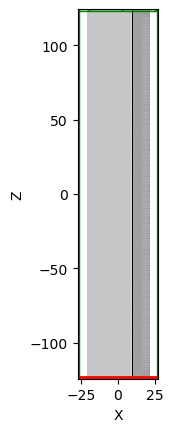

In [ ]:
###---------------------------------------cell setup----------------------------------------------------###
sx = material_H + 2*dpml + 10
sy = 0
sz = sz_length + 2*dpml + 10
cell = mp.Vector3(sx, sy, sz)

fcen = 2.85e12 # 2.85THz
df = 0.2  # pulse frequency width
fceninmeep = fcen/3e8

src = [mp.Source(mp.ContinuousSource(fceninmeep, fwidth=df),
        component=mp.Ey,
        center=mp.Vector3(0,0,-0.5 * sz + dpml),
        size=mp.Vector3(x=sx)
        )]

###-------------------------------------simulation setup-----------------------------------------------###
sim = mp.Simulation(
                cell_size=cell,
                geometry=geometry,
                boundary_layers=[mp.PML(dpml, direction=mp.X),
                                 mp.PML(dpml, direction=mp.Z)],
                sources=src,
                resolution=resolution)
sim.plot2D()
